In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor

from src.data_transform import make_sequence_from_time_series, train_test_split

from src.drawing import show_forecast_test_plot
import matplotlib.pyplot as plt


Создадим свой лстм модуль

In [ ]:
def train_lstm(num_epochs, model, criterion, optimizer, x_train, y_train):
    loss_list = []
    for epoch in range(num_epochs):
        for i in range(len(x_train)):
            optimizer.zero_grad()
            y_pred = model(x_train[i])
            print(y_pred.shape)
            print(y_train[i].shape)
            loss = criterion(y_pred, y_train[i])
            loss_list.append(loss.detach().cpu())
            loss.backward()
            optimizer.step()
        # if (epoch+1) % 10 == 0:
            # print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')
    return loss_list

In [ ]:
def compute_distance(y_pred, y_test):
    return np.absolute((y_pred - y_test)).sum()

обучим по простому

In [ ]:
from pytorch_forecasting.metrics.point import SMAPE
df = pd.read_csv('train.csv')
target = df[['target_value']]

seq_len = 10
x_train = torch.tensor(target.iloc[:350].values).float()
x_test = torch.tensor(target.iloc[350:359].values).float()
y_test = torch.tensor(target.iloc[359:].values).float()

x_train, y_train = train_test_split(x_train, seq_len)

In [ ]:
input_dim = 1
hidden_dim = 64
output_dim = 7


model = OwnLSTM(input_dim, hidden_dim, output_dim)
criterion = SMAPE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
print(model)

In [ ]:
loss_list = train_lstm(num_epochs, model, criterion, optimizer, x_train, y_train)

In [ ]:
# print(loss_list)
# from src.drawing import show_loss_after_train
# y_pred = model(x_test).detach().numpy()
# show_loss_after_train(loss_list)

In [ ]:
# df = pd.read_csv('train.csv')
# time = df.Date
# train = df.target_value.iloc[:359]
# test = df.target_value.iloc[359:]
# pred = y_pred
# print(compute_distance(pred,test))
# show_forecast_test_plot(time, train, pred, test)

теперь добавим нормировку (Standart Scaler)

In [ ]:
# df = pd.read_csv('train.csv')
# target = df[['target_value']]
#
# seq_len = 7
# x_train = torch.tensor(target.iloc[:350].values).float()
# x_test = torch.tensor(target.iloc[350:359].values).float()
# y_test = torch.tensor(target.iloc[359:].values).float()
#
# scaler = StandardScaler()
# x_train = torch.tensor(scaler.fit_transform(x_train)).float()
# x_test = torch.tensor(scaler.transform(x_test)).float()
# y_test = torch.tensor(scaler.transform(y_test)).float()
#
#
# x_train, y_train = train_test_split(x_train, seq_len)


In [ ]:
# input_dim = 1
# hidden_dim = 64
# output_dim = 7
#
#
# model = OwnLSTM(input_dim, hidden_dim, output_dim)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 1000
# print(model)

In [ ]:
# loss_list = train_lstm(num_epochs, model, criterion, optimizer, x_train, y_train)

In [ ]:
y_pred = model(x_test).detach().numpy()
y_pred = scaler.inverse_transform(model(x_test).detach().numpy().reshape(1,-1))

In [ ]:
# plt.figure(figsize=(15, 9))
# plt.plot(loss_list)
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

In [2]:
# df = pd.read_csv('train.csv')
# time = df.Date
# train = df.target_value.iloc[:359]
# test = df.target_value.iloc[359:]
# pred = y_pred[0]
# print(compute_distance(pred, test))
# show_forecast_test_plot(time, train, pred, test)

In [3]:
import pandas as pd
import torch
import torch.nn as nn

## Обработка временного ряда

In [4]:
# Достаем ряд
df = pd.read_csv('train.csv')
target = df.target_value

In [5]:
# Выбираем константы для длины входной последовательности и для длины предсказания
seq_len = 10
predict_horizon = 7

### Масштабирование данных и стабилизация дисперсии

In [6]:
# масштабирование
from src.data_transform import data_scaling
print('Std: ', target.std(), 'Mean: ', target.mean())
target_scaled = data_scaling(target)
print('Std: ', round(target_scaled.std()), 'Mean: ', round(target_scaled.mean()))

Std:  836.4328884415709 Mean:  2078.0138920969944
Std:  1 Mean:  0


Lambda value used for Transformation: -0.43668043973665444
ADF Statistic: -1.551629
p-value: 0.507835
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
The TS is NOT stationary


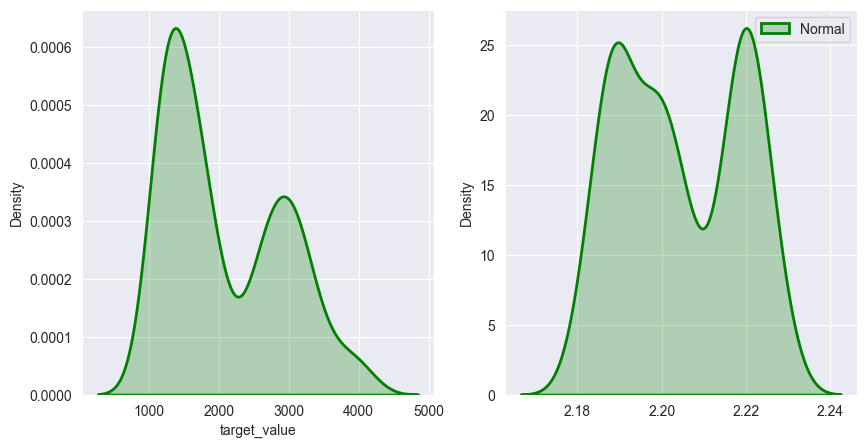

In [7]:
# Стабилизация дисперсии ни к чему не привела
from src.statistic import check_stationarity
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fitted_data, fitted_lambda = stats.boxcox(target)
fig, ax = plt.subplots(1, 2)

sns.distplot(target, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])

plt.legend(loc = "upper right")
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")
check_stationarity(fitted_data)

### Создание последовательностей

### размер выбирается по формуле описанной в этой статье https://arxiv.org/abs/1710.03222

![](sequence.png)
![](train_test_split.png)

In [11]:
from src.data_transform import make_sequence_from_time_series, train_test_split

# разбиваем на трейн и тест ряд
train_data = torch.tensor(target.iloc[: target.shape[0] - seq_len - predict_horizon].values).float()
test_data = torch.tensor(target.iloc[target.shape[0] - seq_len - predict_horizon: ].values).float()

# создаем из этих рядов последовательности
list_of_train_x_seq, list_of_train_y_seq = make_sequence_from_time_series(train_data, seq_len, predict_horizon)
x_test, y_test = make_sequence_from_time_series(test_data, seq_len, predict_horizon)

# разбиваем последовательность обучения на две части, обучение и валидация
x_train, y_train, x_val, y_val = train_test_split(list_of_train_x_seq, list_of_train_y_seq, train_size=0.8)

# создаем из этого датасеты
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

# запихиваем все это в даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15)

# Создадим ЛСТМ нейронку

In [38]:
class OwnLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(OwnLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=5, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.fully_con = nn.Sequential(
            nn.Linear(in_features=hidden_dim, out_features=32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=output_dim)
        )

    def forward(self, time_series):
        print(time_series.shape)
        lstm_out, _ = self.lstm(time_series.view(time_series.shape[0], time_series.shape[1], 1).float())
        y_pred = self.linear(lstm_out.view(len(time_series), -1).float())
        # y_pred = self.fully_con(lstm_out.view(len(time_series), -1).float())
        return y_pred[-7]

In [39]:
from tqdm.notebook import tqdm

def train_lstm(n_epochs, model, loss_fn, optimizer, train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for X_batch, y_real in train_loader:
            optimizer.zero_grad()

            y_pred = model(X_batch.to(device).float())

            loss = loss_fn(y_pred, y_real.to(device))
            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))


        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val, y_real_val in val_loader:
              y_pred_val = model(X_batch_val.to(device).float())
              loss = loss_fn(y_pred_val, y_real_val.to(device).float())
              val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [40]:
input_dim = 1
hidden_dim = 64
output_dim = 7

In [41]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = OwnLSTM(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
print(model)

OwnLSTM(
  (lstm): LSTM(1, 64, num_layers=5, batch_first=True)
  (linear): Linear(in_features=64, out_features=7, bias=True)
  (fully_con): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [ ]:
train_loss, val_loss = train_lstm(num_epochs, model, criterion, optimizer, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([15, 10])


In [17]:
from src.drawing import show_loss_after_train
show_loss_after_train(train_loss, val_loss)

NameError: name 'train_loss' is not defined